Get results by criteria

In [1]:
from glob import glob
import os
import json
import numpy as np
import yaml
import pandas as pd

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d

output_file_name = 'quorum_output_field.yaml'
if os.path.exists(output_file_name):
    os.remove(output_file_name)

centers = {}
manufacturers = {}
strengths = {}
depths = {}
phases = {}

path_list = glob(r'quorum_output_2\fold_0\temp_allClasses\*.gz')
for path in path_list:
    filename = path.split('\\')[-1]
    phase = filename[11:13]
    name = filename.split('_')[0]
    df = pd.read_csv(os.path.join('custom_quorum_2', name, phase + '_info.csv'))
    center = df['Name'].iloc[0].split('-')[0]
    manufacturer = df['Manufacturer'].iloc[0]
    strength = df['Field Strength'].iloc[0]

    centers = update_dict(centers, str(center), filename)
    manufacturers = update_dict(manufacturers, str(manufacturer), filename)
    strengths = update_dict(strengths, str(strength), filename)
    phases = update_dict(phases, str(phase), filename)

with open(r'quorum_output_2\fold_0\temp_allClasses\summary.json', 'r') as fd_in:
    metric_file = json.load(fd_in)['results']['all']
    results_dict = {}
    for current_dict in [centers, manufacturers, strengths, phases]:
        for key in current_dict.keys():
            print(f'{key} = {len(current_dict[key])}')
            current_values = current_dict[key]
            list_of_dict = [x for x in metric_file if x['reference'].split('/')[-1] in current_values]
            mean_dice_list = []
            mean_hausdorff_list = []
            for data_dict in list_of_dict:
                mean_dice_list.append([data_dict['1']['Dice'], data_dict['2']['Dice'], data_dict['3']['Dice']])
                mean_hausdorff_list.append([data_dict['1']['Hausdorff Distance'], data_dict['2']['Hausdorff Distance'], data_dict['3']['Hausdorff Distance']])
            class_dice = np.stack(mean_dice_list, axis=0).mean(axis=0)
            class_hausdorff = np.stack(mean_hausdorff_list, axis=0).mean(axis=0)
            results_dict[key] = {'Hausdorff distance': class_hausdorff.tolist(), 
                                'Mean Hausdorff distance': float(class_hausdorff.mean()), 
                                'Dice score': class_dice.tolist(),
                                'Mean dice score': float(class_dice.mean())}

with open(output_file_name, 'w') as fd:
    yaml.safe_dump(results_dict, fd, default_flow_style=False)
    #for results_dict in results_dicts:
    #    for key in results_dict.keys():
    #        fd.write(key + ': ' + str(results_dict[key]) + '\n')
    #    fd.write('\n')


250001 = 10
250005 = 2
276004 = 2
276005 = 2
276008 = 2
348001 = 6
348002 = 6
348003 = 2
348004 = 8
348007 = 6
616003 = 4
616005 = 2
616010 = 2
703001 = 10
703003 = 2
703004 = 8
724002 = 2
724006 = 4
siemens = 62
philips = 4
ge = 14
1.5 = 66
3.0 = 14
ed = 40
es = 40


Get ED/ES volume

In [5]:
import nibabel as nib
import numpy as np

data = nib.load(r'quorum_output\validation_raw\patient003_ed.nii.gz')
zoom = data.header.get_zooms()
pixel_volume = np.prod(zoom)
print(pixel_volume)
arr = data.get_fdata()
nb_pixels = np.count_nonzero(arr == 1)
print(nb_pixels * pixel_volume)

13.234375
187504.625


In [8]:
%matplotlib qt

import nibabel as nib
import numpy as np
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

def bwperim(bw, n=4):
    """
    perim = bwperim(bw, n=4)
    Find the perimeter of objects in binary images.
    A pixel is part of an object perimeter if its value is one and there
    is at least one zero-valued pixel in its neighborhood.
    By default the neighborhood of a pixel is 4 nearest pixels, but
    if `n` is set to 8 the 8 nearest pixels will be considered.
    Parameters
    ----------
      bw : A black-and-white image
      n : Connectivity. Must be 4 or 8 (default: 8)
    Returns
    -------
      perim : A boolean image
    """

    if n not in (4,8):
        raise ValueError('mahotas.bwperim: n must be 4 or 8')
    rows,cols = bw.shape

    # Translate image by one pixel in all directions
    north = np.zeros((rows,cols))
    south = np.zeros((rows,cols))
    west = np.zeros((rows,cols))
    east = np.zeros((rows,cols))

    north[:-1,:] = bw[1:,:]
    south[1:,:]  = bw[:-1,:]
    west[:,:-1]  = bw[:,1:]
    east[:,1:]   = bw[:,:-1]
    idx = (north == bw) & \
          (south == bw) & \
          (west  == bw) & \
          (east  == bw)
    if n == 8:
        north_east = np.zeros((rows, cols))
        north_west = np.zeros((rows, cols))
        south_east = np.zeros((rows, cols))
        south_west = np.zeros((rows, cols))
        north_east[:-1, 1:]   = bw[1:, :-1]
        north_west[:-1, :-1] = bw[1:, 1:]
        south_east[1:, 1:]     = bw[:-1, :-1]
        south_west[1:, :-1]   = bw[:-1, 1:]
        idx &= (north_east == bw) & \
               (south_east == bw) & \
               (south_west == bw) & \
               (north_west == bw)
    return ~idx * bw

def signed_bwdist(im):
    '''
    Find perim and return masked image (signed/reversed)
    '''    
    perimeter = bwperim(im)

    distance_map = bwdist(perimeter)

    im = -distance_map*np.logical_not(im) + distance_map*im
    return im

def bwdist(im):
    '''
    Find distance map of image
    '''
    dist_im = distance_transform_edt(1-im)
    return dist_im

def interp_shape(arr, new_depth):
    '''
    Interpolate between two contours

    Input: top 
            [X,Y] - Image of top contour (mask)
           bottom
            [X,Y] - Image of bottom contour (mask)
           precision
             float  - % between the images to interpolate 
                Ex: num=0.5 - Interpolate the middle image between top and bottom image
    Output: out
            [X,Y] - Interpolated image at num (%) between top and bottom

    '''
    X, Y, Z = arr.shape

    distance_arr = []
    for i in range(Z):
        distance_arr.append(signed_bwdist(arr[:, :, i]))
    distance_arr = np.stack(distance_arr, axis=-1)

    x = np.arange(0, X)
    y = np.arange(0, Y)
    z = np.arange(0, Z)
    points = (x, y, z)

    stop = Z-1

    # create ndgrids
    grid = np.mgrid[:X, :Y, 0:stop:(new_depth * 1j)]
    xi = np.rollaxis(grid, 0, 4)
    xi = xi.reshape((X * Y * new_depth, 3))

    out = interpn(points, distance_arr, xi)
    out = out.reshape((X, Y, new_depth))

    # Threshold distmap to values above 0
    out = out > 0

    #fig, ax = plt.subplots(2, out.shape[-1])
    #for t in range(out.shape[-1]):
    #    if t < arr.shape[-1]:
    #        ax[0, t].imshow(arr[:, :, t], cmap='gray')
    #    ax[1, t].imshow(out[:, :, t], cmap='gray')
    #plt.show()

    #print(out.shape)

    return out


data = nib.load(r'data_saud_2\inference\patient030_ed.nii.gz')
arr = data.get_fdata()
arr = arr == 1

X, Y, Z = arr.shape
#print(arr.shape)
# Run interpolation
out = interp_shape(arr, Z+1)
#print(out.shape)
#fig, ax = plt.subplots(1, Z+1)
#for i in range(Z+1):
#    ax[i].imshow(out[:, :, i], cmap='gray')
#plt.show()

Get only patient in test set

In [9]:
from glob import glob
import pandas as pd

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d


cut_prediction_path = r'Quorum_trainings\Baseline\fold_0\temp_allClasses'
all_prediction_path = r'data_saud_2\inference'

data_dict_cut = {}
data_dict_all = {}

path_list = glob(os.path.join(cut_prediction_path, '*.gz'))
cut_prediction_names = []
for path in path_list:
    filename = path.split('\\')[-1]
    phase = filename[11:13]
    name = filename.split('_')[0]
    df = pd.read_csv(os.path.join('custom_quorum_2', name, phase + '_info.csv'))
    actual_name = df['Name'].to_numpy()[0]
    spacing = (df['Space Between Slices'] - df['Slice Thickness']).to_numpy()[0]
    cut_prediction_names.append(actual_name)
    if phase == 'ed':
        update_dict(data_dict_cut, 'ed', (path, spacing, actual_name))
    elif phase == 'es':
        update_dict(data_dict_cut, 'es', (path, spacing, actual_name))

csv_list = glob(os.path.join(all_prediction_path, '*.csv'))
for csv_path in csv_list:
    filename = csv_path.split('\\')[-1]
    phase = filename[11:13]
    df = pd.read_csv(csv_path)
    actual_name = df['Name'].to_numpy()[0]
    if actual_name in cut_prediction_names:
        spacing = (df['Space Between Slices'] - df['Slice Thickness']).to_numpy()[0]
        path = csv_path[:-4] + '.nii.gz'
        if phase == 'ed':
            update_dict(data_dict_all, 'ed', (path, spacing, actual_name))
        elif phase == 'es':
            update_dict(data_dict_all, 'es', (path, spacing, actual_name))

Get volume and diseases for jmp

In [10]:
%matplotlib qt

import nibabel as nib
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import csv

df_disease = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload_disease = df_disease.loc[df_disease['Descriptor'] == 'Infarction_Ratio']

#path_list = glob(r'quorum_output_2\temp_allClasses\*.gz')

for data_dict, output_file_name in zip([data_dict_cut, data_dict_all], ['disease_volume_cut.csv', 'disease_volume_all.csv']):
    if os.path.exists(output_file_name):
        os.remove(output_file_name)
    results = []
    for i, class_name in enumerate(tqdm(['RV', 'MYO', 'LV']), 1):
        for phase in data_dict.keys():
            list_of_tuple = data_dict[phase]
            for path, spacing, name in list_of_tuple:
                data = nib.load(path)
                zoom = list(data.header.get_zooms())
                arr = data.get_fdata()
                pixel_size = np.prod(zoom)

                new_depth = round((spacing * (arr.shape[-1] - 1)) / zoom[-1]) + arr.shape[-1]
                #print(arr.shape[-1])
                #print(new_depth)
                #print('******************************')

                class_nb_pixels = arr == i

                volume_no_interp = (pixel_size * class_nb_pixels.sum()) / 1000
                if class_name == 'MYO':
                    volume_no_interp = volume_no_interp * 1.055

                if new_depth > arr.shape[-1]:
                    arr_interpolated = interp_shape(class_nb_pixels, new_depth)
                    volume_interp = (pixel_size * arr_interpolated.sum()) / 1000
                    if class_name == 'MYO':
                        volume_interp = volume_interp * 1.055
                else:
                    volume_interp = volume_no_interp

                if name in payload_disease:
                    infraction_percent = payload_disease[name][0]
                else:
                    infraction_percent = ''

                results.append({'Phase': phase, 'Class': class_name, 'Volume': volume_no_interp, 'Interpolated_volume': volume_interp, 'Infraction_percent': infraction_percent})
            
        #if class_name != 'MYO':
        #    results[class_name].update({
        #        'Fraction d\'ejection': {'no_interpolation': ((results[class_name]['ed']['volume'] - results[class_name]['es']['volume']) / results[class_name]['ed']['volume']) * 100,
        #                                'interpolated': ((results[class_name]['ed']['interpolated_volume'] - results[class_name]['es']['interpolated_volume']) / results[class_name]['ed']['interpolated_volume']) * 100},
        #        'Volume d\'ejection': {'no_interpolation': (results[class_name]['ed']['volume'] - results[class_name]['es']['volume']),
        #                                'interpolated': (results[class_name]['ed']['interpolated_volume'] - results[class_name]['es']['interpolated_volume'])}
        #                                })          

    with open(os.path.join(r'Quorum_trainings\Baseline\fold_0', output_file_name), 'w') as fd:
        writer = csv.DictWriter(fd, fieldnames=list(results[0].keys()))
        writer.writeheader() 
        writer.writerows(results) 

100%|██████████| 3/3 [00:11<00:00,  3.72s/it]


Get disease and dice for jmp

In [ ]:
import json
import os
import csv
import pandas as pd

df = pd.read_excel(r'disease_saud\radiomics_all.xlsx')
payload = df.loc[df['Descriptor'] == 'Infarction_Ratio']

folders = [r'Quorum_trainings\Baseline\fold_0']
for folder in folders:
    results_list = []
    with open(os.path.join(folder, r'temp_allClasses\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            patient_name = res['center']
            if patient_name in payload:
                infraction_percent = payload[patient_name][0]
            else:
                infraction_percent = ''
            results_list.append({'Patient': patient_name, 'Infraction_percent': infraction_percent, 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

    with open(os.path.join(folder, 'disease_jmp.csv'), 'w') as fd_csv:
        writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
        writer.writeheader() 
        writer.writerows(results_list) 
        

Get jmp data

In [5]:
import json
import os
import csv

folders = [r'Quorum_trainings\Baseline', r'Quorum_trainings\no_trans', r'Quorum_trainings\no_sfb', r'Quorum_trainings\no_ds']
results_list = []
for folder in folders:
    with open(os.path.join(folder, r'fold_0\validation_raw\summary.json')) as fd_json:
        data = json.load(fd_json)
        results = data['results']['all']
        for res in results:
            rv_dice = res['1']['Dice']
            myo_dice = res['2']['Dice']
            lv_dice = res['3']['Dice']
            results_list.append({'Method': folder.split('\\')[-1], 'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('Quorum_trainings', 'jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 
        

Get dice for 'temp_allClasses' folder

In [1]:
import json
import os
import csv

results_list = []
with open(r'Quorum_trainings\Baseline\fold_0\temp_allClasses\summary.json') as fd_json:
    data = json.load(fd_json)
    results = data['results']['all']
    for res in results:
        rv_dice = res['1']['Dice']
        myo_dice = res['2']['Dice']
        lv_dice = res['3']['Dice']
        results_list.append({'RV': rv_dice, 'MYO': myo_dice, 'LV': lv_dice, 'Mean': (rv_dice + myo_dice + lv_dice) / 3})

with open(os.path.join('Quorum_trainings\Baseline', 'Quorum_postprocess_allClasses_jmp.csv'), 'w') as fd_csv:
    writer = csv.DictWriter(fd_csv, fieldnames=list(results_list[0].keys()))
    writer.writeheader() 
    writer.writerows(results_list) 

Get images for worst predictions

In [141]:
%matplotlib qt

import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from evaluation.metrics import dice
import cv2 as cv

h = 4
w = int(round(h * (16/9)))

name_list = []
dice_list = []
with open(os.path.join(r'Quorum_trainings\Baseline\fold_0\temp_allClasses\summary.json')) as fd_json:
    data = json.load(fd_json)
    results = data['results']['all']
    for res in results:
        name = res['reference'].split('/')[-1]
        rv_dice = res['1']['Dice']
        myo_dice = res['2']['Dice']
        lv_dice = res['3']['Dice']
        mean = (rv_dice + myo_dice + lv_dice) / 3
        name_list.append(name)
        dice_list.append(mean)

arr = np.stack([np.array(name_list), np.array(dice_list)], axis=0)
indices = np.argsort(arr[1])
arr = arr[:, indices]
arr = arr[0, :h*w]
path_array_pred = np.array(['Quorum_trainings\Baseline\\fold_0\\temp_allClasses\\'])
path_array_gt = np.array(['out\\nnUNet_raw_data_base\\nnUNet_raw_data\Task029_Quorum\labelsTr\\'])
path_array_img = np.array(['out\\nnUNet_raw_data_base\\nnUNet_raw_data\Task029_Quorum\imagesTr\\'])
pred_arr = np.char.add(path_array_pred, arr)
gt_arr = np.char.add(path_array_gt, arr)
img_arr = np.char.add(path_array_img, np.char.rstrip(arr, '.nii.gz'))
img_arr = np.char.add(img_arr, np.array(['_0000.nii.gz']))

fig, ax = plt.subplots(h, w)
fig.tight_layout()
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.1, hspace=0.1)
for idx, (prediction_path, gt_path, img_path) in enumerate(zip(pred_arr, gt_arr, img_arr)):
    pred_data = nib.load(prediction_path)
    pred_arr = pred_data.get_fdata()

    gt_data = nib.load(gt_path)
    gt_arr = gt_data.get_fdata()

    img_data = nib.load(img_path)
    img_arr = img_data.get_fdata()

    score_list = []
    for j in range(pred_arr.shape[-1]):
        score = dice(pred_arr[:, :, j], gt_arr[:, :, j])
        score_list.append(score)
    score_list = np.array(score_list)
    slice_nb = np.argmin(score_list)

    img_arr = img_arr[:, :, slice_nb]
    gt_arr = gt_arr[:, :, slice_nb]
    pred_arr = pred_arr[:, :, slice_nb]

    img_arr = cv.normalize(img_arr, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype(np.uint8)
    img_arr = cv.cvtColor(img_arr, cv.COLOR_GRAY2RGB)

    for j in range(1, 4):
        pred = (pred_arr == j).astype(np.uint8)
        gt = (gt_arr == j).astype(np.uint8)
        pred_contours, hierarchy = cv.findContours(pred, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        gt_contours, hierarchy = cv.findContours(gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        pred_color = [255, 0, 0]
        gt_color = [0, 255, 0]
        img_arr = cv.drawContours(img_arr, pred_contours, -1, pred_color, 1)
        img_arr = cv.drawContours(img_arr, gt_contours, -1, gt_color, 1)

    ax[int(idx//w), int(idx%w)].imshow(img_arr)
    ax[int(idx//w), int(idx%w)].set_axis_off()

plt.savefig("squares.png")
plt.show()

In [106]:
data = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\imagesTr\patient082_ed_0000.nii.gz')
arr = data.get_fdata()

data_gt = nib.load(r'out\nnUNet_raw_data_base\nnUNet_raw_data\Task029_Quorum\labelsTr\patient082_ed.nii.gz')
arr_gt = data_gt.get_fdata()

for i in range(arr.shape[-1]):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(arr[:, :, i], cmap='gray')
    ax[1].imshow(arr_gt[:, :, i], cmap='gray')
    plt.waitforbuttonpress()
    plt.show()
    plt.close(fig)

KeyboardInterrupt: 

Get number of centers

In [2]:
from glob import glob
import pandas as pd
import numpy as np

center_list = []
path_list = glob(r'data_saud_2\3D\**\*.csv', recursive=True)
for path in path_list:
    df = pd.read_csv(path)
    center = df['Name'][0].split('-')[0]
    center_list.append(center)
center_list = np.array(center_list)
out = np.unique(center_list)
print(out)
print(out.size)

['250001' '250005' '276004' '276005' '276006' '276007' '276008' '348001'
 '348002' '348003' '348004' '348007' '616003' '616005' '616006' '616009'
 '616010' '616012' '703001' '703003' '703004' '724002' '724005' '724006']
24


Get dice per depth level

[[], [], []]
[0.83138756 0.88230964 0.91367051]


C:\Users\Portal\AppData\Local\Temp/ipykernel_18828/3983745409.py:69: RuntimeWarning: Mean of empty slice
  class_dice = np.nanmean(class_dice, axis=0)


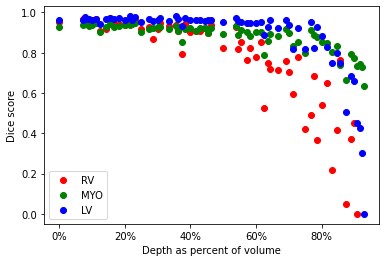

In [14]:
from evaluation.metrics import dice
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from glob import glob
import math
import numpy as np
import nibabel as nib

def update_dict(d, key, value):
    if key not in d:
        d[key] = [value]
    else:
        d[key].append(value)
    return d

path_list = glob(r'Quorum_trainings\Baseline\fold_0\temp_allClasses\*.gz')
path_list_names = [x.split('\\')[-1][:13] for x in path_list]
path_list_gt = glob(r'custom_quorum_2\**\*_gt.nii.gz', recursive=True)
path_list_gt = [x for x in path_list_gt if x.split('\\')[-1][:13] in path_list_names]
assert len(path_list_gt) == len(path_list)

path_list = sorted(path_list, key=lambda x:x.split('\\')[-1])
path_list_gt = sorted(path_list_gt, key=lambda x:x.split('\\')[-1])

out_dict = {}
scores = []
for path, path_gt in zip(path_list, path_list_gt):
    data = nib.load(path)
    arr = data.get_fdata()

    data_gt = nib.load(path_gt)
    arr_gt = data_gt.get_fdata()

    assert arr.shape == arr_gt.shape
    patient_scores = []
    for i in range(arr.shape[-1]):
        #fig, ax = plt.subplots(1, 2)
        #ax[0].imshow(arr[:, :, i], cmap='gray')
        #ax[1].imshow(arr_gt[:, :, i], cmap='gray')
        #plt.show()
        #plt.waitforbuttonpress()
        #plt.close(fig)

        current_pred = arr[:, :, i]
        current_gt = arr_gt[:, :, i]

        #current_pred = arr
        #current_gt = arr_gt

        class_score = []
        for j in range(1, 4):
            current_class_pred = current_pred == j
            current_gt_pred = current_gt == j
            score = dice(current_class_pred, current_gt_pred)
            class_score.append(score)
        out_dict = update_dict(out_dict, key=i/arr.shape[-1], value=np.array(class_score))
        patient_scores.append(np.array(class_score))
    patient_class_score = np.stack(patient_scores, axis=0)
    patient_class_score = np.nanmean(patient_class_score, axis=0)
    scores.append(patient_class_score)
scores = np.stack(scores, 0)
scores = np.nanmean(scores, axis=0)

x = [[], [], []]
y = [[], [], []]
for key in out_dict.keys():
    class_dice = np.stack(out_dict[key], axis=0)
    class_dice = np.nanmean(class_dice, axis=0)
    for i in range(3):
        if not math.isnan(class_dice[i]):
            x[i].append(key)
            y[i].append(class_dice[i])

print(np.array(scores))

fig, ax = plt.subplots(1, 1)
ax.scatter(np.array(x[0]), np.array(y[0]), c='r', label='RV')
ax.scatter(np.array(x[1]), np.array(y[1]), c='g', label='MYO')
ax.scatter(np.array(x[2]), np.array(y[2]), c='b', label='LV')
ax.set(xlabel='Depth as percent of volume', ylabel='Dice score')
ax.legend()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))